# Image Classifier

**By**: Daksh Gupta

**Project Description:**

***Libraries Required:*** OpenCV 3.1.0

This is an image classifier, that classifies images as Spam or Notspam. Here Spam images refer to images that have large amount of text, memes, cartoons etc. and Notspam images in general are clicked pictures of humans, landscapes, animals etc.

I have manually collected and labeled my dataset which has a total of 3,412 images. The images are my personal clicks and images I think of as SPAM from my WhatsApp images folder.

The classifier uses the following features to describe the images:

- No. of faces in the image
- No. of distinct color in the image
- % area of image covered by text
- % area of image covered by top color 1
- % area of image covered by top color 2
- % area of image covered by top color 3
- % area of image covered by top color 4
- % area of image covered by top color 5
- % area of image covered by top color 6
- % area of image covered by top color 7
- % area of image covered by top color 8
- % area of image covered by top color 9
- % area of image covered by top color 10

From basic experimentation, I found that in general, Spam images have very less number of unique colors and the ones that they have share a occupy a large number of image pixels. On the other hand, Notspam images have a large number of unique colors.

To get a proper number of unique colors, I have considered only the colors/shades that occupy more than 0.5% of the image.

I will be using Logistic Regression with L2 regularization to train and classify this data.

***To Run:***

Place the images in a folder called 'data' in the same folder as the Notebook. The structure of the folder should be like "*data\\notspam (1).jpeg; data\\notspam (2).jpeg; .....; data\\spam (1).jpg ...*"

There is a 'data.pckl' and 'labels.pckl' file with the Notebook, these contain the data matrix and the target variable numpy array respectively. The code below gives preference to loading the data from the .pckl files over processing the images again and again.



In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
'''
This function detects the percentage of image covered with text. It doesn't use techniques like OCR (optical character recognition)
rather it uses edge detection and thresholding to determin the location of text.

Because of this it never returns 0% ever, since all images have edges.
'''
def detectTextArea(img):
    img_gray = img
    if len(img.shape) > 2:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_sobel = cv2.Sobel(img_gray, cv2.CV_8U, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    _, img_threshold = cv2.threshold(img_sobel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    element = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 3))
    img_threshold = cv2.morphologyEx(img_threshold, cv2.MORPH_CLOSE, element)
    image, contours, heirarchy = cv2.findContours(img_threshold, 0, 1)
    boundRect = []
    area = 0
    for contour in contours:
        # print(contour.size)
        if contour.size > 100:
            contours_poly = cv2.approxPolyDP(contour, 3, True)
            rect = cv2.boundingRect(contours_poly)
#             print(rect)
            area += rect[2]*rect[3]
            if rect[2] > rect[3]:
                boundRect.append(rect)
                
    return area/img_gray.size, boundRect

In [3]:
'''
This function detects and returns the number of faces in the provided image. The faces are supposed to have an almost neutral
emotion and SHADES don't work.
'''

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# face_cascade = cv2.CascadeClassifier('haarcascade_profileface.xml')


def faceCounter(img, cascade=face_cascade):
    img_gray = img
    if len(img.shape) > 2:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_eq = cv2.equalizeHist(img_gray)
#     key = 0
#     while key != 27:
#         cv2.imshow('disp',img_eq)
#         key = cv2.waitKey()
    faces = cascade.detectMultiScale(img_eq,minSize=(50, 50),flags=1,scaleFactor=1.2)
    return len(faces)

In [4]:
'''
This function returns the number of unique shades of gray present in the image. It filters out shades that occupy less than
0.5% of the image.

The reason for doing this is to get only the visually impactful colors instead of all of them. For example, a screenshot of a 
notepad document with text contains all 256 shades, but the visually impactful are just two ,i.e., Black and White.
'''
def getUniqueColors(img):
    img_gray = img
    if len(img.shape) > 2:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    total_pixels = img_gray.size
    x, counts = np.unique(img_gray, return_counts=True)
    colors = []
    area = []
#     print(x.size)
    for i in range(x.size):
        if float(counts[i])/total_pixels > 0.005:
#             print(x[i])
            colors.append(x[i])
#             print()
            area.append(float(counts[i])/total_pixels)
    area.sort(reverse = True)
#     print(colors, area)
    return len(colors), area

In [5]:
'''
This code snippet forms the data and label matrices
'''

data = np.ones((2,2),np.float32)
labels = np.ones((1),np.int32)
if not os.path.exists('data.pckl') and not os.path.exists('labels.pckl'):
    data = np.ones((2,2),np.float32)
    labels = np.ones((1),np.int32)
    for dirname, dirnames, filenames in os.walk('data'):
        total_ex = len(filenames)
        data = np.zeros((total_ex,13),np.float32)
        labels = np.zeros((total_ex),np.int32)
        for i, file in enumerate(filenames):
            if file.startswith('spam'):
                labels[i] = 1
            else:
                labels[i] = 0
            print(os.path.join(dirname,file))
            img = cv2.imread(os.path.join(dirname,file),0)
            h,w = img.shape[:2]
            ratio = w/float(h)
            img = cv2.resize(img, (int(ratio*720),720))
            faces = faceCounter(img)
            colors, area = getUniqueColors(img)
            txtarea, _ = detectTextArea(img)
            data[i,0] = faces
            data[i,1] = colors
            data[i,2] = txtarea
            for j in range(10):
                if j < colors:
                    data[i,j+3] = area[j]
    
    pickle.dump(data, open('data.pckl','wb'))
    pickle.dump(labels, open('labels.pckl','wb'))
else:
    data = pickle.load(open('data.pckl','rb'))
    labels = pickle.load(open('labels.pckl','rb'))

data\notspam (1).jpg
data\notspam (10).jpg
data\notspam (100).jpg
data\notspam (1000).jpg
data\notspam (1001).jpg
data\notspam (1002).jpg
data\notspam (1003).jpg
data\notspam (1004).jpg
data\notspam (1005).jpg
data\notspam (1006).jpg
data\notspam (1007).jpg
data\notspam (1008).jpg
data\notspam (1009).jpg
data\notspam (101).jpg
data\notspam (1010).jpg
data\notspam (1011).jpg
data\notspam (1013).jpg
data\notspam (1014).jpg
data\notspam (1015).jpg
data\notspam (1017).jpg
data\notspam (1018).jpg
data\notspam (1019).jpg
data\notspam (102).JPG
data\notspam (1020).jpg
data\notspam (1021).jpg
data\notspam (1022).jpg
data\notspam (1023).jpg
data\notspam (1024).jpg
data\notspam (1028).jpg
data\notspam (1030).jpg
data\notspam (1031).jpg
data\notspam (1032).jpg
data\notspam (1033).jpg
data\notspam (1034).jpg
data\notspam (1035).jpg
data\notspam (1036).jpg
data\notspam (1037).jpg
data\notspam (1038).jpg
data\notspam (1039).jpg
data\notspam (1040).jpg
data\notspam (1041).jpg
data\notspam (1042).jpg


In [6]:
data.shape

(3412, 13)

## Bar plot for Class variable

I have two classes: Spam and Notspam

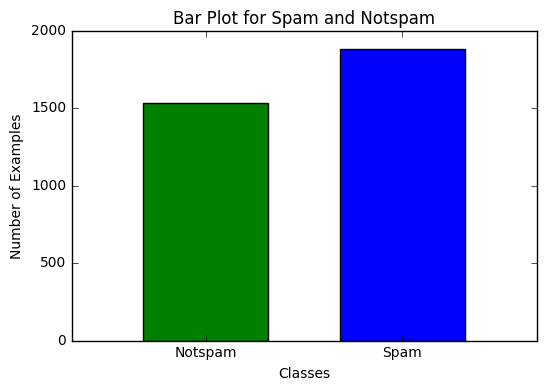

In [7]:
%matplotlib inline

label, counts = np.unique(labels, return_counts = True)

fig = plt.figure()
ax = fig.add_subplot(111)

width = 0.35

N = np.arange(2)

rect1 = ax.bar(0.2, counts[0], width, color='green')

rect2 = ax.bar(0.2+width+0.2, counts[1], width, color='blue')

ax.set_ylabel('Number of Examples')
ax.set_title('Bar Plot for Spam and Notspam')
lab = []
if label[0] == 0:
    lab = ['Notspam', 'Spam']
else:
    lab = ['Spam', 'Notspam']
ax.set_xlim(0,1.3)
ax.set_xticks([0.2+0.175, 0.4+0.35+0.175])
ax.set_xticklabels(lab)
ax.set_xlabel('Classes')
plt.show()


## Feature Statisctics/Histograms

I have a total of 13 features

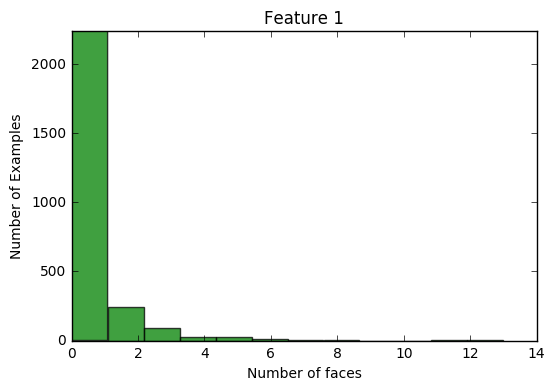

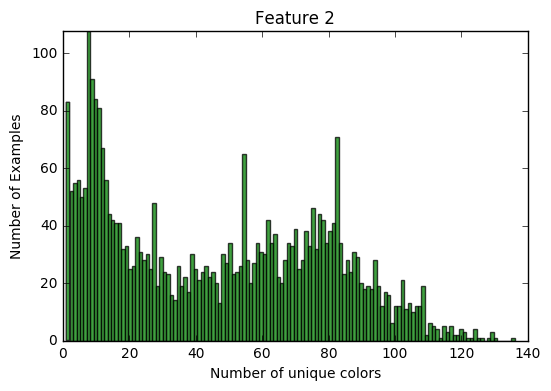

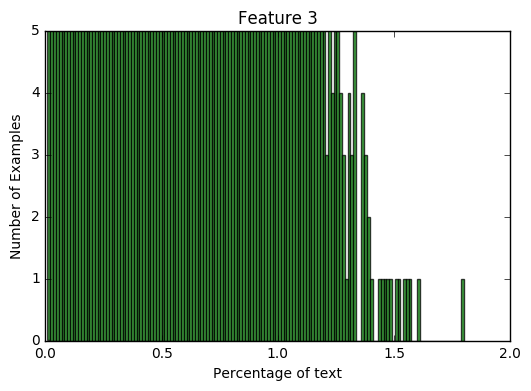

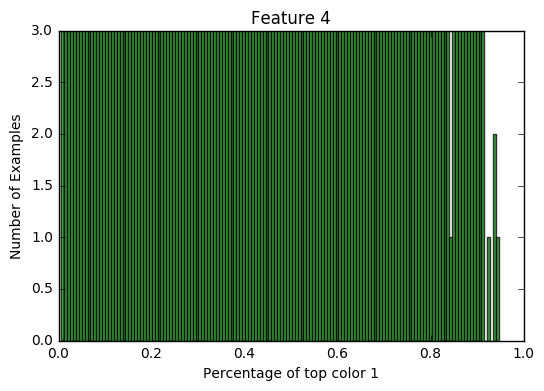

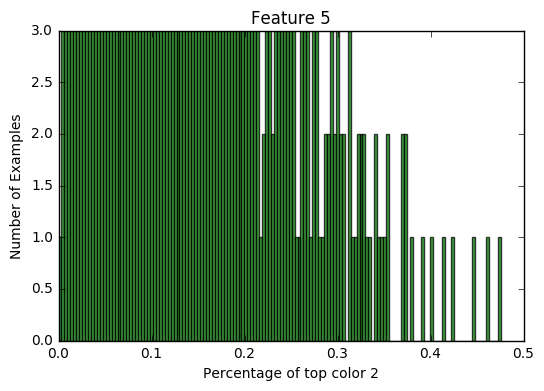

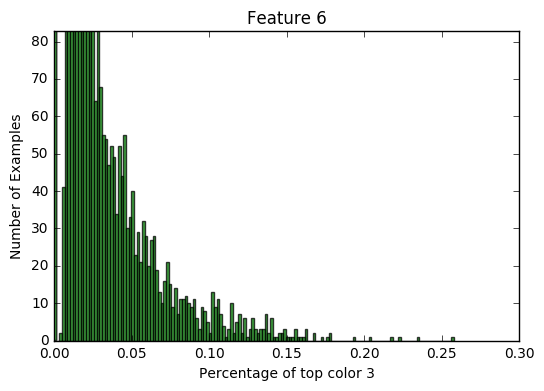

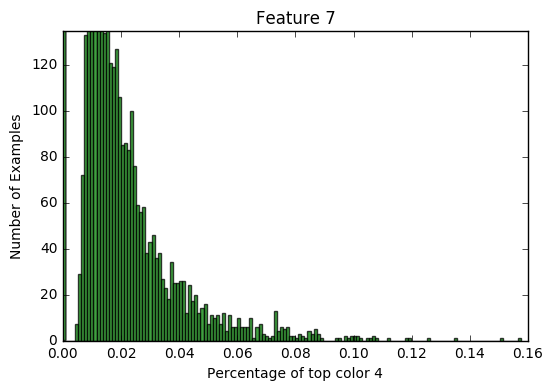

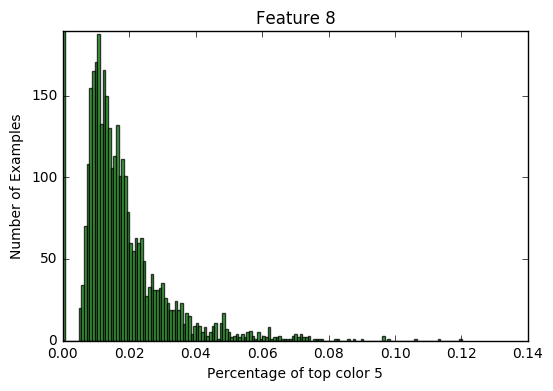

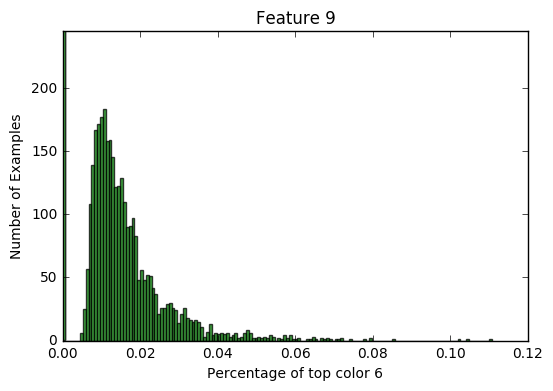

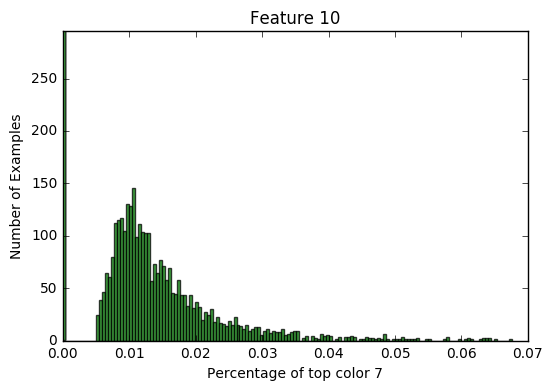

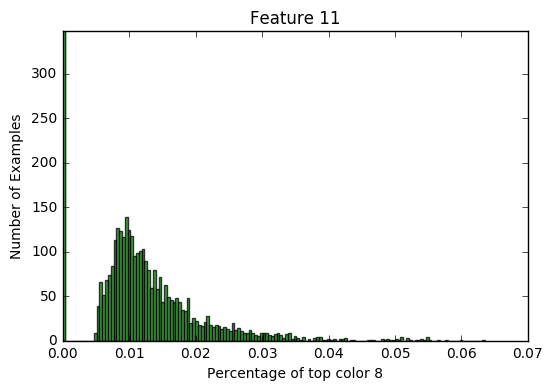

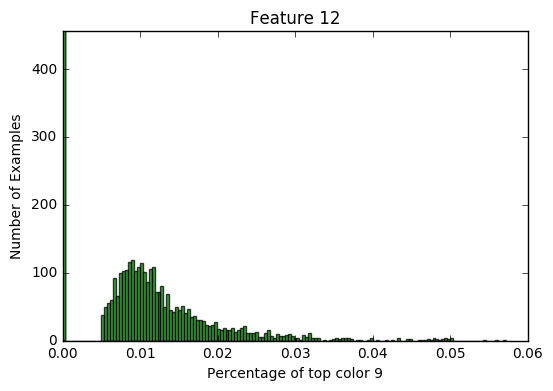

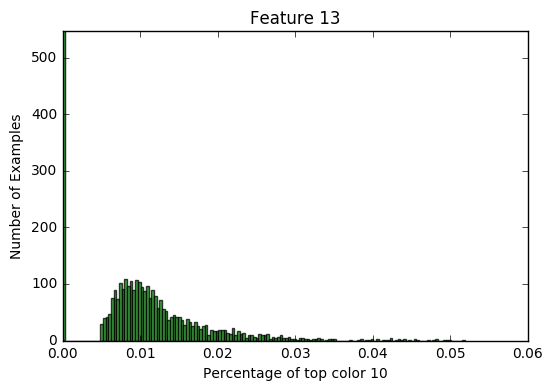

In [8]:
xlabels = ['Number of faces', 'Number of unique colors', 'Percentage of text',
           'Percentage of top color 1',
           'Percentage of top color 2',
           'Percentage of top color 3',
           'Percentage of top color 4',
           'Percentage of top color 5',
           'Percentage of top color 6',
           'Percentage of top color 7',
           'Percentage of top color 8',
           'Percentage of top color 9',
           'Percentage of top color 10'
          ]
for i in range(13):
    fig = plt.figure()
    bins, counts = np.unique(data[:,i], return_counts = True)
    bins = bins.size
    if bins > 150:
        bins = 150
    maxcount = counts.max()
    n,bins,patches = plt.hist(data[:,i],bins,facecolor='green',alpha=0.75)
    plt.ylim(0,maxcount)
    plt.xlabel(xlabels[i])
    plt.ylabel('Number of Examples')
    plt.title('Feature {}'.format(i+1))
    plt.show()